In [1]:
%matplotlib inline
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import time
import re
import seaborn
from lxml import html
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

Получаем 250 самых топовых фильмов

In [116]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url) # получили объект Responce, откуда можно доставать инфу. responce.text выдаст json со всей информацией
soup = BeautifulSoup(response.text, 'lxml')

Парсим страницу с фильмами и получаем грязные данные с


1.   Названием фильма
2.   Рейтингом
3.   Командой 
4.   Ссылкой на основную страницу




In [117]:
movies = soup.select('td.titleColumn')
links = [a.attrs.get('href') for a in soup.select('td.titleColumn a')]
crew = [a.attrs.get('title') for a in soup.select('td.titleColumn a')]
ratings = [b.attrs.get('data-value') for b in soup.select('td.posterColumn span[name=ir]')]

In [119]:
data_frame = {
    "movies": movies,
    "ratings": ratings,
    "crew": crew,
    "links": links
}

data = pd.DataFrame(data_frame)
data

,movies,ratings,crew,links
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.2399979267515,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161028343978032,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993939610639524,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990132719552369,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.9508104396831,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/
...,...,...,...,...
245,"[\n 246.\n , [Красавица и чудовище],...",8.016665120439816,"Gary Trousdale (dir.), Paige O'Hara, Robby Benson",/title/tt0101414/
246,"[\n 247.\n , [Ганди], \n, [(1982)], \n]",8.015279306576245,"Richard Attenborough (dir.), Ben Kingsley, Joh...",/title/tt0083987/
247,"[\n 248.\n , [Прислуга], \n, [(2011)...",8.014437597995268,"Tate Taylor (dir.), Emma Stone, Viola Davis",/title/tt1454029/
248,"[\n 249.\n , [Служанка], \n, [(2016)...",8.012793995849506,"Park Chan-wook (dir.), Kim Min-hee, Ha Jung-woo",/title/tt4016934/


Несколько функциий для преобзразования грязных заголовков с названием фильмов


In [5]:
def process_text_mv(text):
    data = text.get_text().split("\n")
    return data[2].strip()

In [6]:
def process_text_year(text):
    data = text.get_text().split("\n")
    return data[3].strip()[1:-1]

In [7]:
data["title"] = data.movies.apply(process_text_mv)
data["year"] = data.movies.apply(process_text_year)

In [9]:
data.head(5)

,movies,ratings,crew,links,title,year
0,"[\n 1.\n , [Побег из Шоушенка], \n, ...",9.239997546889738,"Frank Darabont (dir.), Tim Robbins, Morgan Fre...",/title/tt0111161/,Побег из Шоушенка,1994
1,"[\n 2.\n , [Крёстный отец], \n, [(19...",9.161005339655771,"Francis Ford Coppola (dir.), Marlon Brando, Al...",/title/tt0068646/,Крёстный отец,1972
2,"[\n 3.\n , [Темный рыцарь], \n, [(20...",8.993896456324507,"Christopher Nolan (dir.), Christian Bale, Heat...",/title/tt0468569/,Темный рыцарь,2008
3,"[\n 4.\n , [Крёстный отец 2], \n, [(...",8.990127722437204,"Francis Ford Coppola (dir.), Al Pacino, Robert...",/title/tt0071562/,Крёстный отец 2,1974
4,"[\n 5.\n , [12 рaзгневанных мужчин],...",8.950794039403767,"Sidney Lumet (dir.), Henry Fonda, Lee J. Cobb",/title/tt0050083/,12 рaзгневанных мужчин,1957


Задача 1.
Получить список всех участников команд (убрать постфикс `(dir.)` у директоров). Найти количество уникальных имен.

In [14]:
list_of_crew = []
for line in data['crew']:
    list_of_crew.append([i for i in line.split(', ')])
list_of_crew_corrected = []
for line in list_of_crew:
    for member in line:
        list_of_crew_corrected.append(re.sub(' \(dir.\)', '', str(member)))
# это список участников (не будем целиком печатать):
print(list_of_crew_corrected[:2])
# это количество уникальных имён:
print(len(set(list_of_crew_corrected)))

['Frank Darabont', 'Tim Robbins']
526


Задача 2.
Получить список всех директоров. Построить распределение (визуализация обязательна) и найти директора(ов), у которого(ых) больше всего фильмов в топе.

In [13]:
directors = []
for i in list_of_crew:
    directors.append(i[0])
directors[:2]
# directors = список всех режиссеров

['Frank Darabont (dir.)', 'Francis Ford Coppola (dir.)']

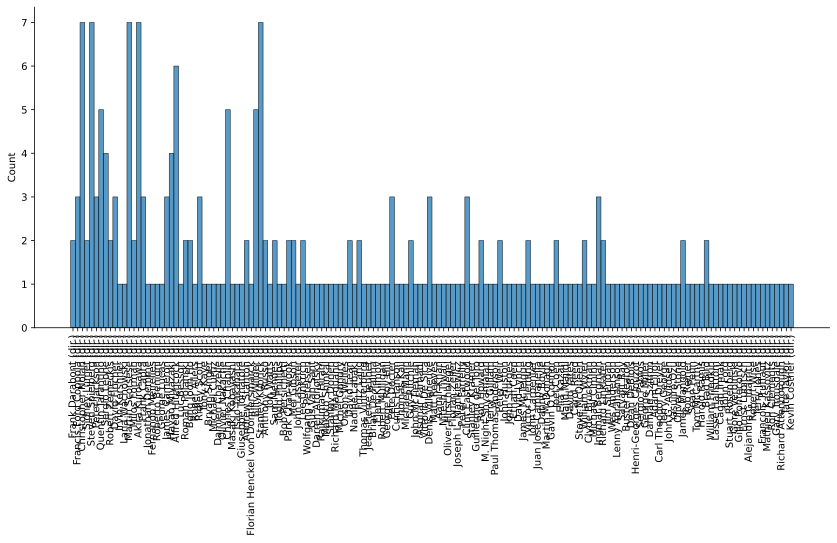

In [15]:
p = sns.displot(data = directors, height=5, aspect=12/5)
plt.xticks(rotation=90)
plt.show()

In [16]:
Counter(directors).most_common(10)
# режиссеры с наибольшим числом фильмов

[('Christopher Nolan (dir.)', 7),
 ('Steven Spielberg (dir.)', 7),
 ('Martin Scorsese (dir.)', 7),
 ('Akira Kurosawa (dir.)', 7),
 ('Stanley Kubrick (dir.)', 7),
 ('Alfred Hitchcock (dir.)', 6),
 ('Quentin Tarantino (dir.)', 5),
 ('Charles Chaplin (dir.)', 5),
 ('Billy Wilder (dir.)', 5),
 ('Sergio Leone (dir.)', 4)]

Задача 3. Найти участника(ов) команд, у которого(ых) больше всего фильмов в топе.

In [17]:
Counter(list_of_crew_corrected).most_common(10)

[('Charles Chaplin', 10),
 ('Robert De Niro', 9),
 ('Clint Eastwood', 8),
 ('Christopher Nolan', 7),
 ('Steven Spielberg', 7),
 ('Martin Scorsese', 7),
 ('Akira Kurosawa', 7),
 ('Stanley Kubrick', 7),
 ('Tom Hanks', 6),
 ('Harrison Ford', 6)]

Задача 4. Построить распределение топовых фильмов по годам

In [126]:
q = Counter(data['year'])
df_q = pd.DataFrame.from_dict(Counter(q), orient='index').reset_index()
df_q = df_q.rename(columns={'index':'year', 0:'films'})
df_q.sort_values(by='year').head(5)

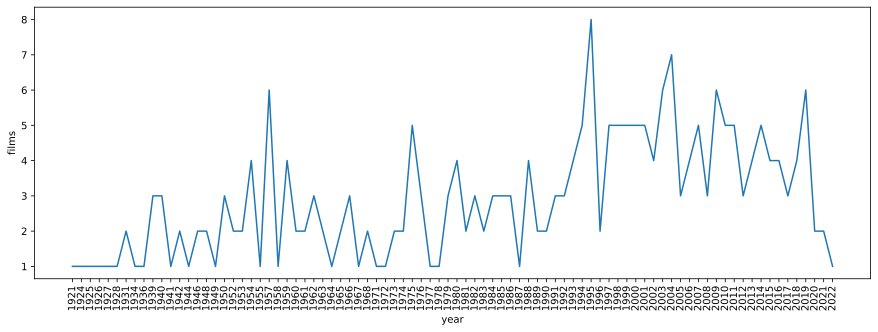

In [19]:
plt.subplots(figsize=(15, 5))
p = sns.lineplot(data = df_q.sort_values(by='year'), x = 'year', y = 'films')
plt.xticks(rotation=90)
plt.show()

Задача 5. Построить распределение топовых фильмов рейтингу:


*   Округлить до сотых и отрисовать
*   Округлить до десятых и отрисовать
*   Округлить до целых и отрисовать

In [20]:
def round_to_hundredths(x):
    return round(float(x), 2)

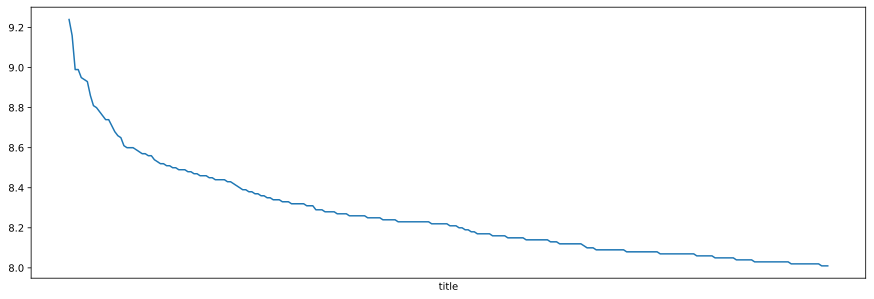

None


In [21]:
plt.subplots(figsize=(15, 5))
p = sns.lineplot(data = data, x = 'title', y = list(map(round_to_hundredths,data['ratings'])))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
print(plt.show())

In [22]:
def round_to_tenths(x):
    return round(float(x), 1)

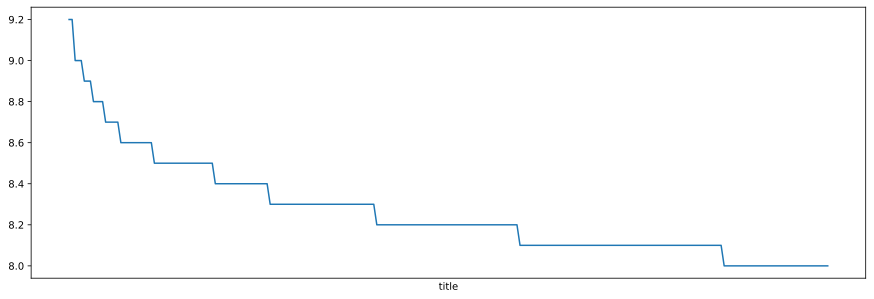

None


In [23]:
plt.subplots(figsize=(15, 5))
p = sns.lineplot(data = data, x = 'title', y = list(map(round_to_tenths,data['ratings'])))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
print(plt.show())

In [24]:
def round_to_whole(x):
    return round(float(x))

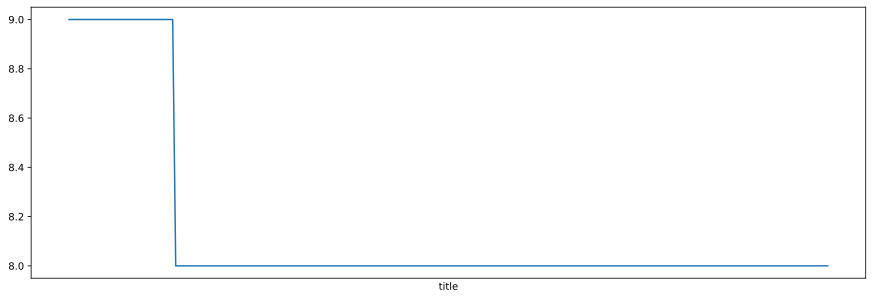

None


In [25]:
plt.subplots(figsize=(15, 5))
p = sns.lineplot(data = data, x = 'title', y = list(map(round_to_whole,data['ratings'])))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
print(plt.show())



Задача 6. Используйте ссылку `http://www.imdb.com/` и динамически добавляя ссылку на фильм из колонки `links` соберите описание фильмов. Пример поиска необходимого текст представлен ниже. Добавьте эту информацию в исходный датафрейм.










In [26]:
film_url = 'http://www.imdb.com/title/tt0068646/'
html_text = requests.get(film_url).text

In [27]:
soup = BeautifulSoup(html_text, 'lxml')
soup.find_all(attrs={"name": "description"})[0].get("content")

'Крёстный отец: Directed by Francis Ford Coppola. With Marlon Brando, Al Pacino, James Caan, Richard S. Castellano. The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.'

In [29]:
# вход: x = /title/tt0068646/
def description_extractor(x):
    film_url = 'http://www.imdb.com'+str(x)
    html_text = requests.get(film_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    return soup.find_all(attrs={"name": "description"})[0].get("content")
  

In [30]:
data['description'] = list(map(description_extractor,(data['links'])))
data['description']

0      Побег из Шоушенка: Directed by Frank Darabont....
1      Крёстный отец: Directed by Francis Ford Coppol...
2      Темный рыцарь: Directed by Christopher Nolan. ...
3      Крёстный отец 2: Directed by Francis Ford Copp...
4      12 рaзгневанных мужчин: Directed by Sidney Lum...
                             ...                        
245    Красавица и чудовище: Directed by Gary Trousda...
246    Ганди: Directed by Richard Attenborough. With ...
247    Прислуга: Directed by Tate Taylor. With Emma S...
248    Служанка: Directed by Park Chan-wook. With Kim...
249    Танцующий с волками: Directed by Kevin Costner...
Name: description, Length: 250, dtype: object

Задача 7. С помощью регулярных выражений найдите в текстах описания фильмов имена актеров, если это возможно (то есть - они там упоминаются). Добавьте эту информацию в датафрейм и посчитайте, для скольких фильмов получилось это сдлеать. Подсказка: перечисление актеров иногда начинается с with. 

In [31]:
def find_actors(x):
    return re.findall(r'(?<=With )[^.]*', x)

In [32]:
data['actors'] = list(map(find_actors,(data['description'])))
data['actors']

0      [Tim Robbins, Morgan Freeman, Bob Gunton, Will...
1      [Marlon Brando, Al Pacino, James Caan, Richard S]
2      [Christian Bale, Heath Ledger, Aaron Eckhart, ...
3      [Al Pacino, Robert Duvall, Diane Keaton, Rober...
4                   [Martin Balsam, John Fiedler, Lee J]
                             ...                        
245    [Robby Benson, Jesse Corti, Rex Everhart, Ange...
246    [Ben Kingsley, Rohini Hattangadi, Roshan Seth,...
247    [Emma Stone, Viola Davis, Bryce Dallas Howard,...
248    [Kim Tae-ri, Yong-nyeo Lee, Min-chae Yoo, Dong...
249    [Kevin Costner, Mary McDonnell, Graham Greene,...
Name: actors, Length: 250, dtype: object

In [33]:
empty = 0
for i in data['actors']:
    if i == '':
        empty+=1
empty

0

Что-то удалось извлечь для всех текстов, хотя не везде правильно, т.к. некоторые имена содержат точку и пробел, по типу John F. Kennedy, поэтому такие имена обрезались.

Задача 8. Распарсите исходную страницу с топ-250 фильмов и получите для каждого фильмов количество оценок. Пример текста в исходной странице:`9.2 based on 2,554,919 user ratings`. Из этого текста нужно достать = `2,554,919`. Подсказка: используя метод `find_all` с аргументом `attrs` в который нужно передать `{'class': 'ratingColumn imdbRating'}` от страници `http://www.imdb.com/chart/top`. Найдите 10 фильмов (вывести их название и кол-во оценок) у которых, самое большое количество оценок.

In [34]:
url = 'http://www.imdb.com/chart/top'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'lxml')

data['number_of_ratings'] = [int(a.attrs.get('title')[13:-13].replace(',','')) for a in soup.select('td.ratingColumn strong')]
data['number_of_ratings']

0      2563855
1      1764620
2      2526068
3      1221559
4       757282
        ...   
245     438012
246     226635
247     446805
248     136328
249     257189
Name: number_of_ratings, Length: 250, dtype: int64

In [35]:
data.sort_values(by='number_of_ratings', ascending = False).head(10)[['title','number_of_ratings']]

,title,number_of_ratings
0,Побег из Шоушенка,2563855
2,Темный рыцарь,2526068
12,Начало,2250528
11,Бойцовский клуб,2017526
10,Форрест Гамп,1977786
7,Криминальное чтиво,1968788
15,Матрица,1846304
8,Властелин колец: Братство кольца,1786440
6,Властелин колец: Возвращение короля,1764654
1,Крёстный отец,1764620


Задача 9. Постройте топ 10 слов, которые встречаются 

1.   в названии фильмов
2.   в описании фильмов
3.   в названии и в описании фильмов

In [65]:
import string
from nltk.tokenize import word_tokenize

from pymystem3 import Mystem
import os, json
mystem = Mystem()

words_in_titles = []
for film in data['title']:
    word = [i for i in word_tokenize(film)]
    word = list(filter(lambda token: token not in string.punctuation, word))
    words_in_titles.append(word) 
words_in_titles_flatten = [item.lower() for sublist in words_in_titles for item in sublist]
words_in_titles_flatten_lemmatized = [mystem.lemmatize(i)[0] for i in words_in_titles_flatten if i.isalpha()==True]
Counter(words_in_titles_flatten_lemmatized).most_common(10)

[('в', 11),
 ('и', 9),
 ('на', 8),
 ('отец', 5),
 ('кольцо', 4),
 ('война', 4),
 ('жизнь', 4),
 ('история', 4),
 ('большой', 4),
 ('по', 4)]

In [66]:
import string
from nltk.tokenize import word_tokenize

from pymystem3 import Mystem
import os, json
mystem = Mystem()

words_in_description = []
for description in data['description']:
    word = [i for i in word_tokenize(description)]
    word = list(filter(lambda token: token not in string.punctuation, word))
    words_in_description.append(word) 
words_in_description_flatten = [item.lower() for sublist in words for item in sublist]
words_in_description_flatten_lemmatized = [mystem.lemmatize(i)[0] for i in words_in_description_flatten if i.isalpha()==True]
Counter(words_in_description_flatten_lemmatized).most_common(10)

[('a', 388),
 ('the', 365),
 ('with', 312),
 ('by', 294),
 ('directed', 250),
 ('to', 233),
 ('of', 204),
 ('and', 178),
 ('in', 152),
 ('his', 145)]

Поскольку слова, которые встречаются в описаниях, фигурируют намного больше раз, то очевидно, что если соединить эти списки (названия+описания), то списко наиболее частотных будет совпадать со списком слов из описаний.




Задача 10*. Спарсить теги фильмов со страницы каждого фильма, так например для `The Godfather` ожидается получить список из `Crime, Drama`. (Можно увидеть эти теги по картинкой к фильму)


In [125]:
# вход: x = /title/tt0068646/
def genres_extractor(x):
    film_url = 'http://www.imdb.com'+str(x)
    html_text = requests.get(film_url).text
    soup = BeautifulSoup(html_text, 'lxml')
    genres = []
    for i in soup.find_all('div', attrs={"data-testid": "genres"})[0].find_all('span',attrs={'role': 'presentation'}):
        genres.append(i.get_text())
    return genres

data['genres'] = list(map(genres_extractor,(data['links'])))
data['genres']

0                           [Drama]
1                    [Crime, Drama]
2            [Action, Crime, Drama]
3                    [Crime, Drama]
4                    [Crime, Drama]
                   ...             
245    [Animation, Family, Fantasy]
246              [Biography, Drama]
247                         [Drama]
248      [Drama, Romance, Thriller]
249     [Adventure, Drama, Western]
Name: genres, Length: 250, dtype: object